<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Cats_vs_Dogs_TFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook covers the following:
- Loading up the cats-vs-dogs dataset from TensorFlow Datasets (`tfds`).
- Converting the dataset to TF Records and moving them to a publicly available GCS Bukcet.
- Parsing the TF Records' files and visualizing them. 
- Timing the performance. 

## Setup

In [ ]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
# Other imports
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import os
from tqdm.notebook import tqdm

tfds.disable_progress_bar()

tf.random.set_seed(666)

## Cats vs. Dogs dataset

In [ ]:
# Cats-vs-Dogs dataset
train_ds, validation_ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteW0R3EB/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Utils for creating TF Records

In [ ]:
IMG_SHAPE = 224

# Basic Preprocessing utility
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.cast(image, tf.float32)
  image = image
  return (image, label)

In [ ]:
# Preprocess
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# We need to convert the image to byte strings
# https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg
def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

# Recompress the images
def recompress_dataset(dataset):
    dataset = dataset.map(recompress_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32) # more on this later
    return dataset

In [ ]:
# Convert to byte strings
train_ds = recompress_dataset(train_ds)
validation_ds = recompress_dataset(validation_ds)

In [ ]:
# Images are byte-strings
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

# Classes would be integers
def _int_feature(list_of_ints): 
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

# Function that prepares a record for the tfrecord file
# a record contains the image and its label
def to_tfrecord(img_bytes, label):  
    # print(class_num)
    feature = {
      "image": _bytestring_feature([img_bytes]), 
      "class": _int_feature([label]),             
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
# Prepare tfrecords
def prepare_tfrecords(dataset, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for shard, (image, label) in enumerate(tqdm(dataset)):
        shard_size = image.numpy().shape[0]
        filename = output_dir + "/catsdogs-" + "{:02d}-{}.tfrec".format(shard, shard_size)

        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(shard_size):
                example = to_tfrecord(image.numpy()[i],label.numpy()[i])
                out_file.write(example.SerializeToString())
            print("Wrote file {} containing {} records".format(filename, shard_size))

## Create TF Records! 

In [ ]:
# Prepare the training set
prepare_tfrecords(train_ds, "train_tfr")

Wrote file train_tfr/catsdogs-00-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-01-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-02-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-03-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-04-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-05-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-06-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-07-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-08-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-09-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-10-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-11-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-12-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-13-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-14-32.tfrec containing 32 records
Wrote file train_tfr/catsdogs-15-32.tfre

In [ ]:
# Prepare the validation set
prepare_tfrecords(validation_ds, "valid_tfr")

Wrote file valid_tfr/catsdogs-00-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-01-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-02-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-03-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-04-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-05-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-06-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-07-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-08-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-09-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-10-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-11-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-12-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-13-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-14-32.tfrec containing 32 records
Wrote file valid_tfr/catsdogs-15-32.tfre

## Set up GCP and move to a GCS Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
!gsutil -m cp -r train_tfr/*.tfrec gs://cats-vs-dogs-wandb
!gsutil -m cp -r valid_tfr/*.tfrec gs://cats-vs-dogs-wandb

To learn how to create a public bucket, follow this link: https://cloud.google.com/storage/docs/access-control/making-data-public. 

## Parse the TF Records and visualize them

In [ ]:
import re

# Function to read the TFRecords, segregate the images and labels
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [224, 224, 3]) 
    class_label = tf.cast(example['class'], tf.int32)
    
    return (image, class_label)

# Load the TFRecords and create tf.data.Dataset
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

# We need this to derive the steps for generator
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Batch, shuffle, and repeat the dataset and pre-fetch it
# well before the current epoch ends
def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(1000)
    else:
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 
    return (dataset, n//batch_size)

In [ ]:
# Let's load up the tfrecord filenames
tfrecord_pattern = "train_tfr/*.tfrec"
train_filenames = tf.io.gfile.glob(tfrecord_pattern)
train_filenames[:10]

['train_tfr/catsdogs-606-32.tfrec',
 'train_tfr/catsdogs-292-32.tfrec',
 'train_tfr/catsdogs-357-32.tfrec',
 'train_tfr/catsdogs-429-32.tfrec',
 'train_tfr/catsdogs-573-32.tfrec',
 'train_tfr/catsdogs-370-32.tfrec',
 'train_tfr/catsdogs-115-32.tfrec',
 'train_tfr/catsdogs-353-32.tfrec',
 'train_tfr/catsdogs-107-32.tfrec',
 'train_tfr/catsdogs-587-32.tfrec']

In [ ]:
tfr_pattern_test = "valid_tfr/*.tfrec"
valid_filenames = tf.io.gfile.glob(tfr_pattern_test)
valid_filenames[:5]

['valid_tfr/catsdogs-107-32.tfrec',
 'valid_tfr/catsdogs-84-32.tfrec',
 'valid_tfr/catsdogs-44-32.tfrec',
 'valid_tfr/catsdogs-81-32.tfrec',
 'valid_tfr/catsdogs-68-32.tfrec']

In [ ]:
import matplotlib.pyplot as plt

CLASSES = ['cat', 'dog']

# Visual inspection
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
        
    return (numpy_images, numpy_labels)

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[labels[i]]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;

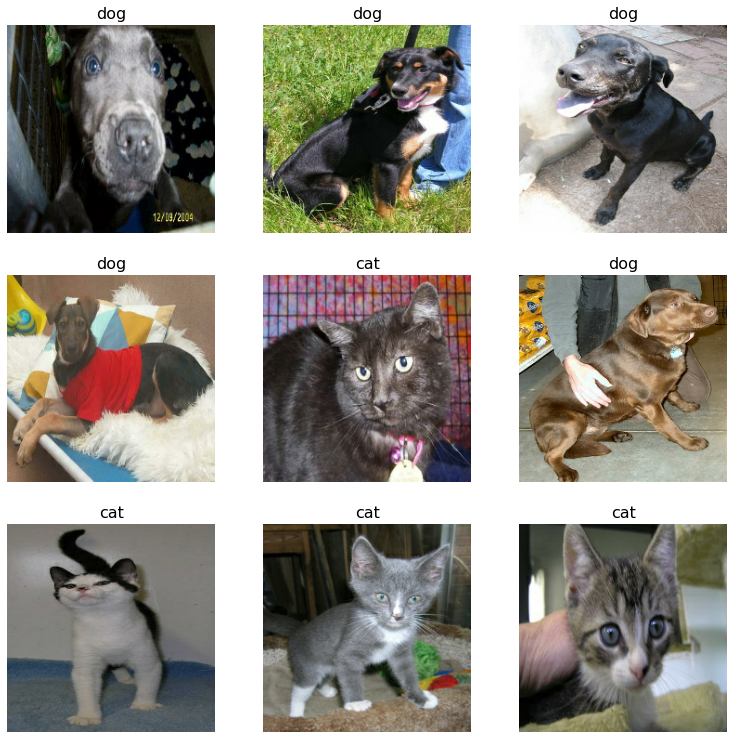

In [ ]:
# Training set
display_9_images_from_dataset(load_dataset(train_filenames))

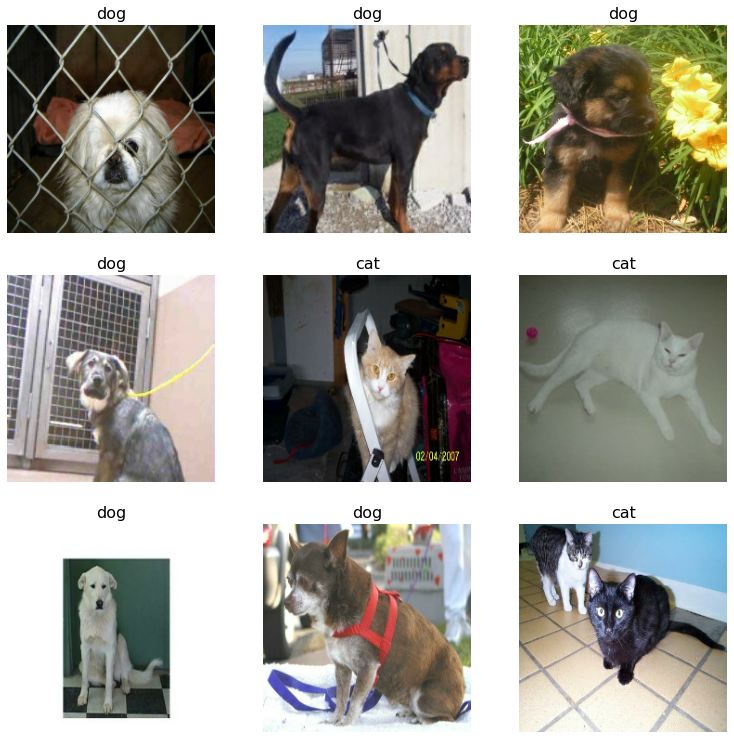

In [ ]:
# Validation set
display_9_images_from_dataset(load_dataset(valid_filenames))

## Performance

In [ ]:
# Measure performance
import time

default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(32*steps/duration))

In [ ]:
training_dataset, _ = batch_dataset(train_filenames, 32, True)
timeit(training_dataset)

....................................................................................................
1000 batches: 28.973335027694702 s
1104.46381 Images/s


## References:
- https://nbviewer.jupyter.org/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/keras_flowers_gputputpupod_tf2.1.ipynb
- https://www.tensorflow.org/guide/data_performance